In [1]:
%matplotlib widget
import spikeinterface.full as si
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

# Write here the location of the test dataset that you downloaded
data_path = Path("/Users/vigji/Desktop/test-compression/test-data")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
recording = si.load_extractor(data_path)

In [3]:
# We can directly read from here a lot of information about the recording, just some examples:
recording.get_total_duration()

100.0

In [4]:
recording.sampling_frequency  # sampling frequency

30000.0

In [5]:
recording.channel_ids[:10]  # channel ids

array(['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AP9',
       'AP10'], dtype='<U5')

In [6]:
# You can discover more options reading the docs or typing:
dir(recording)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_bin_kwargs',
 '_channel_slice',
 '_check_segment_index',
 '_dtype',
 '_extra_metadata_from_folder',
 '_extra_metadata_to_folder',
 '_frame_slice',
 '_get_file_path',
 '_kwargs',
 '_main_annotations',
 '_main_features',
 '_main_ids',
 '_main_properties',
 '_preferred_mp_context',
 '_properties',
 '_recording_segments',
 '_remove_channels',
 '_sampling_frequency',
 '_save',
 '_select_segments',
 '_serializablility',
 '_skip_properties',
 'add_recording_segment',
 'annotate',
 'astype',
 'binary_compatible_with',
 'channel_ids',
 'channel_slice',
 'check_if_json_serializable',
 'check_if_memory_serializabl

(-100.0, 400.0)

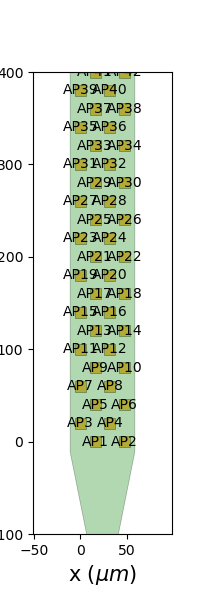

In [7]:
# We can also get a nice view of the probe layout:

fig, ax = plt.subplots(figsize=(2, 6))
si.plot_probe_map(recording, ax=ax, with_channel_ids=True)
ax.set_ylim(-100, 400)

In [8]:
# To get a nice pandas datrame with all probe information:
recording.get_probe().to_dataframe()

,x,y,contact_shapes,width,shank_ids,contact_ids
0,16.0,0.0,square,12.0,,e0
1,48.0,0.0,square,12.0,,e1
2,0.0,20.0,square,12.0,,e2
3,32.0,20.0,square,12.0,,e3
4,16.0,40.0,square,12.0,,e4
...,...,...,...,...,...,...
379,32.0,3780.0,square,12.0,,e379
380,16.0,3800.0,square,12.0,,e380
381,48.0,3800.0,square,12.0,,e381
382,0.0,3820.0,square,12.0,,e382


## Accessing the raw data

Sometimes we want to have a look at the data as a familiar numpy array. While loading a full recording will blow up our RAM,
we could load single channels or small time chunks using the `.get_traces()` method:

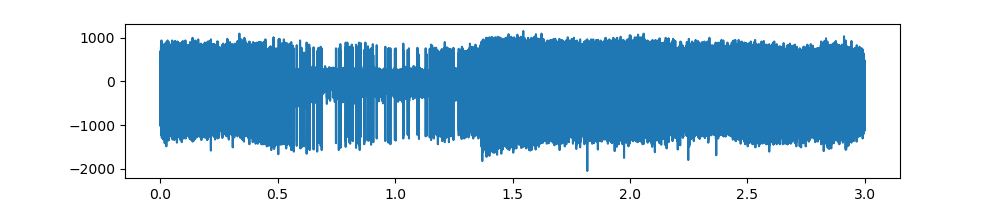

In [26]:
## Get trace for a single channel (flatten to be 1D array):
selected_channels = [257]
channel_trace = recording.get_traces(channel_ids=[recording.channel_ids[i] for i in [selected_channels]]).flatten()

# Zoom in in the plot to have a look at all the little spikes!
plt.figure(figsize=(10, 2))
plt.plot(channel_trace)

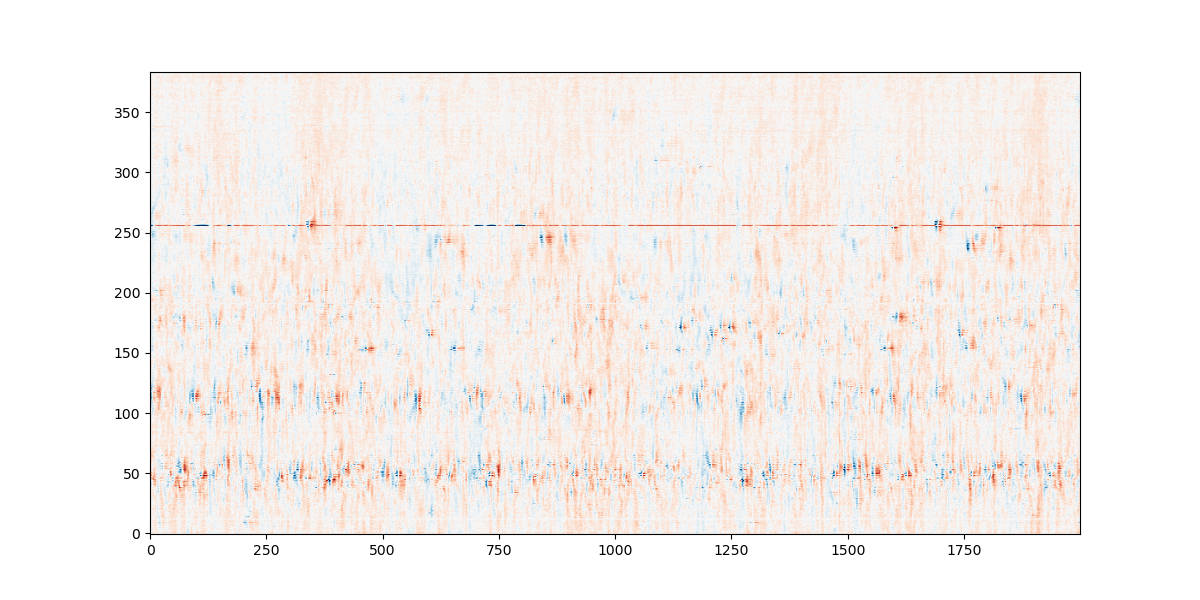

In [10]:
# We can also get all channels within some time range
start_frame = 136000  # start frame for the segment
end_frame = 138000  # end frame for the segment - total, 0.1 second

# Get the segment of recording as a NumPy array
segment = recording.get_traces(start_frame=start_frame, end_frame=end_frame)#, channel_ids=channel_ids)

# and show it using matplotlib:
plt.figure(figsize=(12, 6))
plt.imshow(segment.T, aspect='auto', vmin=-1000, vmax=1000, cmap="RdBu_r", origin='lower')


## Visualizing raw data

Extracting and visualizing numpy arrays can be cumbersome with very large datasets. For this reason, `spikeinterface` provides a nice function, `plot_traces()`, for visualization. This function relies on **lazy loading**: when you make the plot, only the segment that you are asking t be plotted will be loaded in memory, so we obtain the same effects that we had above without the need to load explicitely data as numpy arrays.

The plot_traces function can be used to make either raw traces plots or `imshow` views as the last above.

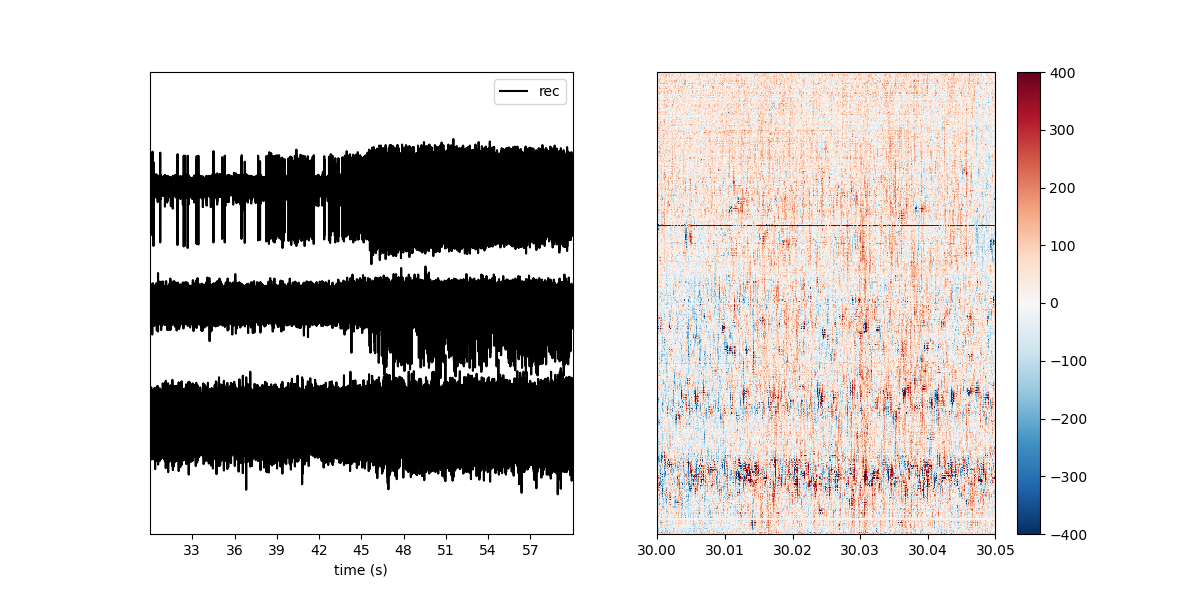

In [11]:
# By default, with < 64 channels, plots will be traces, otherwise raster plot with color
f, axs = plt.subplots(1, 2, figsize=(12, 6))
si.plot_traces(recording, 
               channel_ids=[recording.channel_ids[i] for i in [50, 100, 257]],
               time_range=(30, 60),
               backend='matplotlib',
               ax=axs[0])

si.plot_traces(recording, 
               time_range=(30, 30.05),
               backend='matplotlib',
               clim=(-400, 400),
               ax=axs[1])

In [12]:
# In the notebook, we can also use the ipywidgets backend to have a fancy interactive tool:
si.plot_traces(recording, 
               # channel_ids=[recording.channel_ids[i] for i in [50, 100, 257]],
               time_range=(30, 30.1),
               backend='ipywidgets',
               width_cm=30)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [13]:
# There are other viewers: 
# - ephyviewer (not a fan)
# - sortingview (looks very promising, but did not dig into it yet)

## Preprocessing pipelines

In `spikeinterface` we can configure very easily processing pipelines through which our data will get before spike extraction.

The nice thing about `spikeinterface` is that the pipekine is configured before actually being run, and it is very easy to assess 
the effect of a given preprocessing by plotting intermediate results before running long computations.

In [14]:
# Example: let's say we want to implement an high-pass filter:
highpass = si.highpass_filter(recording, freq_min=300.)


# We can quickly assess the effects of this filtering using the plot_traces function, and having
# multiple layers in place:
si.plot_traces(dict(rec=recording, hpass=highpass), 
               # channel_ids=[recording.channel_ids[i] for i in [50, 100, 257]],
               time_range=(30, 30.1),
               backend='ipywidgets',
               width_cm=30)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [15]:
# you might have noticed that some channels are fishy, and most likely come from dead channels on the probe.
# We can easily identify and remove them with dedicated functions:
bad_channel_ids, channel_labels = si.detect_bad_channels(recording)
chan_fixed = si.interpolate_bad_channels(recording, bad_channel_ids)

In [23]:
bad_channel_ids

array(['AP13', 'AP192', 'AP257', 'AP384'], dtype='<U5')

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_51021/1999530964.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axs = plt.subplots(1, len(bad_channel_ids), figsize=(12, 6))


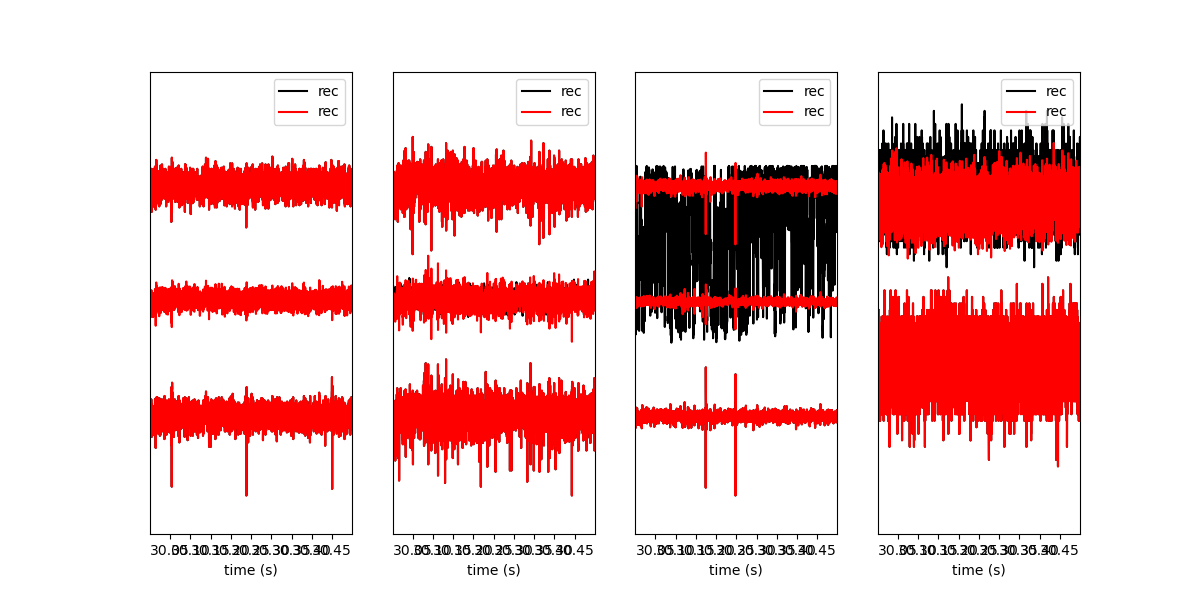

In [37]:
f, axs = plt.subplots(1, len(bad_channel_ids), figsize=(12, 6))

for chan, ax in zip(bad_channel_ids, axs):
    chan_idx = np.argwhere(recording.channel_ids ==chan)[0, 0]
    si.plot_traces(recording,
                   channel_ids=recording.channel_ids[chan_idx-1:chan_idx+2],
                   time_range=(30, 30.5),
                   backend='matplotlib',
                   ax=ax)
    si.plot_traces(chan_fixed,
                   channel_ids=recording.channel_ids[chan_idx-1:chan_idx+2],
                   time_range=(30, 30.5),
                   backend='matplotlib',
                   color='r',
                   ax=ax)
    
    
    # ax.set(ylim=(-5000, 5000))

In [40]:
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(highpass)
rec4 = si.common_reference(rec3, operator="median", reference="global")

bad_channel_ids ['AP13' 'AP192' 'AP257' 'AP384']


In [41]:
# We can quickly assess the effects of this filtering using the plot_traces function, and having
# multiple layers in place:
si.plot_traces(dict(rec=recording, hpass=highpass, pshift=rec3, common_ref=rec4), 
               # channel_ids=[recording.channel_ids[i] for i in [50, 100, 257]],
               time_range=(30, 30.1),
               backend='ipywidgets',
               width_cm=30)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…